># Ensemble

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Dataset/data.zip'

In [5]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

In [6]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/data'
SIZE = 224
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1)

Processing Images: 100%|██████████| 10379/10379 [00:19<00:00, 521.73it/s]


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [8]:
batch_size = 32
picture_size = (224, 224)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed = 22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed = 22
)

Found 10379 files belonging to 38 classes.
Using 8304 files for training.
Found 10379 files belonging to 38 classes.
Using 2075 files for validation.


In [10]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [11]:
no_of_classes = 38

# Define the Xception base model
base_model = Xception(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

# Create three instances of the base model with different inputs
input_1 = base_model.input
output_1 = base_model.output
input_2 = base_model.input
output_2 = base_model.output
input_3 = base_model.input
output_3 = base_model.output

# Add global average pooling layer and dense layers for each model
output_1 = GlobalAveragePooling2D()(output_1)
output_1 = Dense(512, activation='relu')(output_1)
output_1 = Dropout(0.5)(output_1)
output_1 = Dense(32, activation='relu')(output_1)
output_1 = Dense(no_of_classes, activation='softmax')(output_1)

output_2 = GlobalAveragePooling2D()(output_2)
output_2 = Dense(512, activation='relu')(output_2)
output_2 = Dropout(0.5)(output_2)
output_2 = Dense(32, activation='relu')(output_2)
output_2 = Dense(no_of_classes, activation='softmax')(output_2)

output_3 = GlobalAveragePooling2D()(output_3)
output_3 = Dense(512, activation='relu')(output_3)
output_3 = Dropout(0.5)(output_3)
output_3 = Dense(32, activation='relu')(output_3)
output_3 = Dense(no_of_classes, activation='softmax')(output_3)

# Create three separate models
model_1 = Model(inputs=input_1, outputs=output_1)
model_2 = Model(inputs=input_2, outputs=output_2)
model_3 = Model(inputs=input_3, outputs=output_3)

# Compile the models
model_1.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])
model_2.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])
model_3.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

83683744/83683744 [==============================] - 5s 0us/step


In [12]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=2,
                                verbose=1)

callbacks = [lr_scheduler, early_stopping]

In [13]:
# Train model 1
model_1.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 2
model_2.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 3
model_3.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

Epoch 1/10
260/260 [==============================] - 183s 563ms/step - loss: 2.4822 - accuracy: 0.2696 - val_loss: 2.0212 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 2/10
260/260 [==============================] - 139s 536ms/step - loss: 0.9507 - accuracy: 0.6904 - val_loss: 0.8281 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 3/10
260/260 [==============================] - 138s 532ms/step - loss: 0.5395 - accuracy: 0.8332 - val_loss: 0.7048 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/10
260/260 [==============================] - 138s 531ms/step - loss: 0.3788 - accuracy: 0.8868 - val_loss: 1.1691 - val_accuracy: 0.7335 - lr: 0.0010
Epoch 5/10
260/260 [==============================] - 138s 532ms/step - loss: 0.2889 - accuracy: 0.9159 - val_loss: 0.5663 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 6/10
260/260 [==============================] - 139s 533ms/step - loss: 0.1987 - accuracy: 0.9436 - val_loss: 0.3665 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 7/10
260/260 [==========================

In [14]:
ensemble_predictions = []
num_models = 3
test_data_dir = '/content/data'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Generate predictions for each model and collect them in a list
for model in [model_1, model_2, model_3]:
    predictions = model.predict_generator(test_generator)
    ensemble_predictions.append(predictions)

# Compute the average predictions of the ensemble
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Calculate the accuracy of the ensemble predictions
ensemble_acc = np.mean(np.argmax(ensemble_predictions, axis=1) == test_generator.classes)

print('Ensemble accuracy:', ensemble_acc)

Found 10379 images belonging to 38 classes.
Ensemble accuracy: 0.9704210424896426


325/325 [==============================] - 47s 143ms/step
Accuracy: 0.9543308603911745


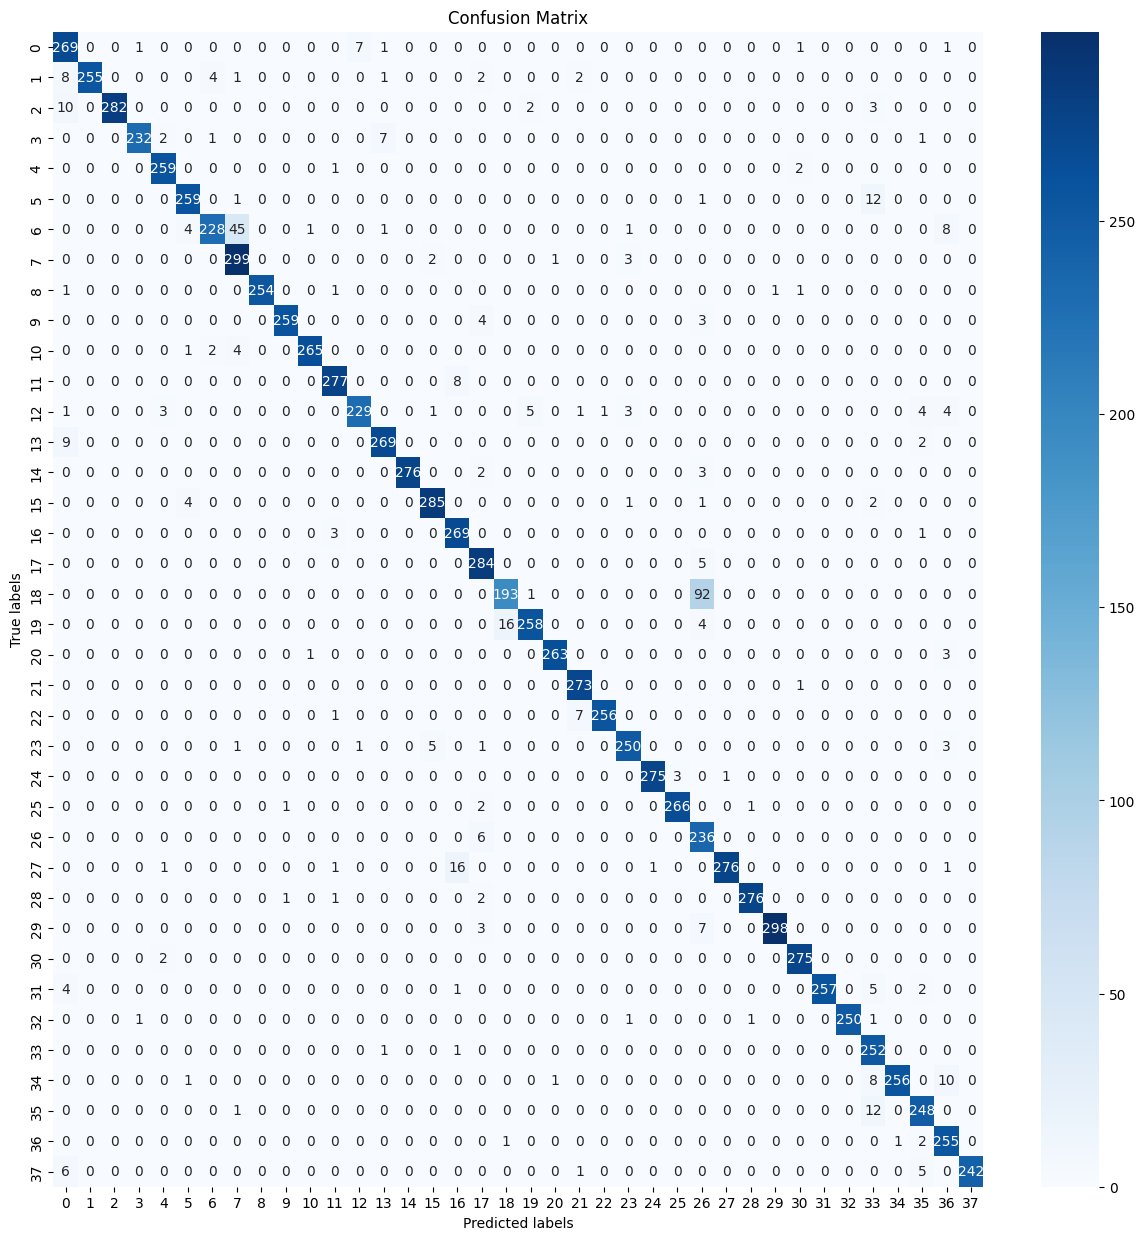

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       280
           1       1.00      0.93      0.97       273
           2       1.00      0.95      0.97       297
           3       0.99      0.95      0.97       243
           4       0.97      0.99      0.98       262
           5       0.96      0.95      0.96       273
           6       0.97      0.79      0.87       288
           7       0.85      0.98      0.91       305
           8       1.00      0.98      0.99       258
           9       0.99      0.97      0.98       266
          10       0.99      0.97      0.98       272
          11       0.97      0.97      0.97       285
          12       0.97      0.91      0.94       252
          13       0.96      0.96      0.96       280
          14       1.00      0.98      0.99       281
          15       0.97      0.97      0.97       293
          16       0.91      0.99      0.95       273
    

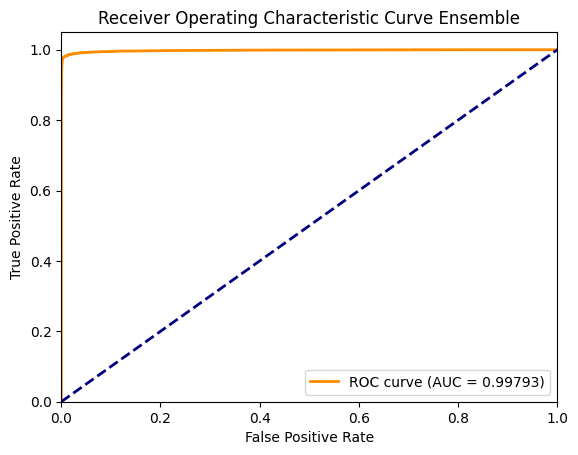

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve Ensemble')
plt.legend(loc="lower right")
plt.show()